## Imports

In [2]:
import tifffile as tf 
import zarr 
import umap
# import palom
# import pillow
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.spatial import ConvexHull, Delaunay
import pickle
import os
import time
# import torch
# import torch.nn as nn
from tqdm.auto import tqdm
import numpy as np
import tifffile as tf
import zarr
import dask.array as da
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cellcutter
import cellcutter.cli
from numcodecs import Blosc

## Other Stuff

In [3]:
IMG_PATH = '/Users/swarchol/Downloads/exemplar-001/image.ome.tif'
CSV_PATH = '/Users/swarchol/Downloads/exemplar-001/df.csv'
SEGMENTATION_PATH = '/Users/swarchol/Downloads/exemplar-001/image.mask.ome.tif'

In [4]:
df = pd.read_csv(CSV_PATH)


## Make Embedding

In [5]:
# df
# Drop these columns UMAP_X UMAP_Y kmeans EEMB_x EEMB_y cluster agglomerative
df = df.drop(columns=['UMAP_X', 'UMAP_Y', 'kmeans', 'EEMB_x', 'EEMB_y', 'cluster', 'agglomerative'])

In [6]:
columns = [  'ELANE', 'CD57', 'CD45', 'CD11B', 'SMA',
       'CD16', 'ECAD', 'FOXP3', 'NCAM',
       'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'Solidity', 'Extent', 'Orientation']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/ps/x7v31pds3gn4t11djwg0t03h0000gp/T/ipykernel_88383/253571037.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap='viridis')


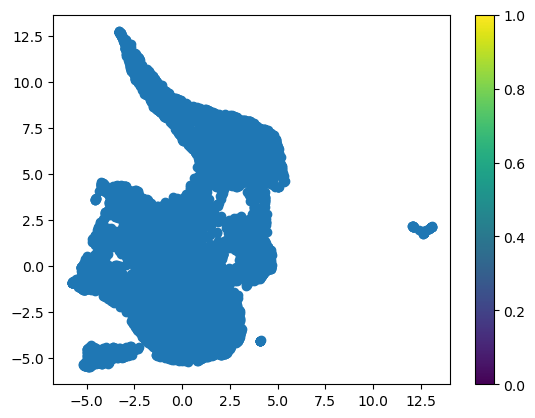

In [7]:
columns = ['ELANE', 'CD57', 'CD45','CD11B', 'SMA',
       'CD16', 'ECAD', 'FOXP3', 'NCAM',
    ]

feature_numpy = df[columns].to_numpy()
# log transform
feature_numpy = np.log1p(feature_numpy)
# handle nans
feature_numpy = np.nan_to_num(feature_numpy)
# UMAP
umap_model = umap.UMAP(n_components=2)
embedding = umap_model.fit_transform(feature_numpy)

# visualize
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='viridis')
plt.colorbar()
plt.show()




In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans.fit(embedding)

# Add the cluster labels to the features dataframe
df['cluster'] = kmeans.labels_

/Users/swarchol/mambaforge/envs/jupyter/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/var/folders/ps/x7v31pds3gn4t11djwg0t03h0000gp/T/ipykernel_88383/3496829216.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(df['X_centroid'], df['Y_centroid'], cmap='viridis')


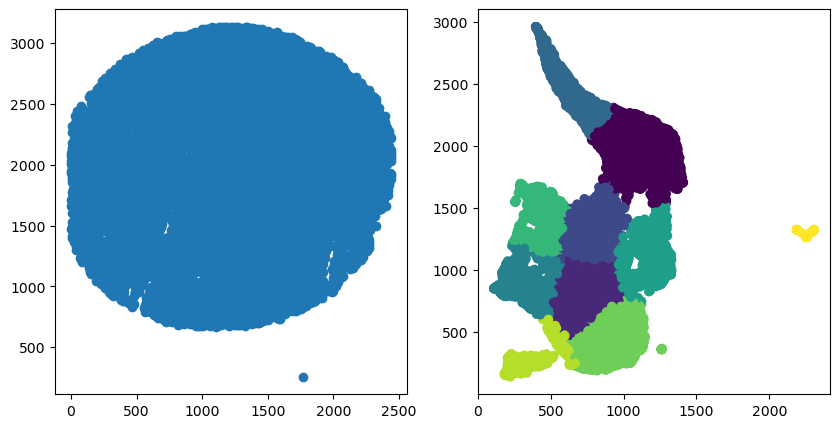

In [9]:
# scale embedding to 0-1 
embedding = (embedding - embedding.min(axis=0)) / (embedding.max(axis=0) - embedding.min(axis=0))

# Get max of X_centroid and Y_centroid
max_x = df['X_centroid'].max()
max_y = df['Y_centroid'].max()
# Scale X and Y of embedding to max of X_centroid and Y_centroid
embedding[:, 0] = embedding[:, 0] * max_x
embedding[:, 1] = embedding[:, 1] * max_y
embedding[:, 0] += (max_x*0.05)
embedding[:, 1] += (max_y*0.05)
embedding[:, 0] = embedding[:, 0] * 0.9
embedding[:, 1] = embedding[:, 1] * 0.9
# visualize on subplots with x_centroid and y_centroid on the right plot and embedding on the left plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(df['X_centroid'], df['Y_centroid'], cmap='viridis')
# axs[0].colorbar()
axs[1].scatter(embedding[:, 0], embedding[:, 1], c=df['cluster'], cmap='viridis')
# axs[1].colorbar()
plt.show()

In [10]:
df['UMAP_X'] = embedding[:, 0]
df['UMAP_Y'] = embedding[:, 1]
# Save to csv
df.to_csv('/Users/swarchol/Downloads/exemplar-001/embedded.csv', index=False)

In [11]:
CSV_PATH = '/Users/swarchol/Downloads/exemplar-001/embedded.csv'

## Cell Cutter

In [12]:
dest_path = "/Users/swarchol/Downloads/exemplar-001/cut"

# # %%
# img = (tf.TiffFile(IMG_PATH, is_ome=False))

# # %%



# # %%
# # remove existing cut directory
# if os.path.exists(dest_path):
#     shutil.rmtree(dest_path)
# for i in tqdm(range(len(img.pages))):
#     sample_path = f"{dest_path}/channel_{i}"
#     args = [IMG_PATH,
#     SEGMENTATION_PATH,
#     '/Users/swarchol/Downloads/exemplar-001/df.csv',
#     sample_path,
#     "-p", "8",  # Number of processes
#         "--channels", (str(i+1)),  # Specific channels to include
#         "--cache-size", str(1024 * 1024 * 1024 * 4),  # Cache size
#     ]
#     cellcutter.cli.cut(args)
    

In [13]:
# # Now Create the Mask
# sample_path = f"{dest_path}/mask"
# args = [IMG_PATH,
# SEGMENTATION_PATH,
# CSV_PATH,
# sample_path,
# "-p", "8",  # Number of processes
#     "--channels", (str(1)),  # Specific channels to include
#     "--cache-size", str(1024 * 1024 * 1024 * 4),  # Cache size
#     "--mask-cells"
    
# ]
# cellcutter.cli.cut(args)
# # Remove the mask directory but keep mask_mask
# import shutil
# shutil.rmtree(f"{dest_path}/mask")
# shutil.move(f"{dest_path}/mask_mask", f"{dest_path}/mask")
# paths_list = [f"{dest_path}/channel_{i}" for i in range(len(img.pages))]
# zarr_list = [zarr.open(path) for path in paths_list]
# # remove existing combined zarr
# if os.path.exists(dest_path + "/combined"):
#     shutil.rmtree(dest_path + "/combined")
# combined_store = zarr.DirectoryStore(dest_path + "/combined")# [r.chunks for r in zarr_list]
# combined = zarr.create(
#             store=combined_store,
#             overwrite=True,
#             shape=(len(zarr_list), zarr_list[0].shape[1],zarr_list[0].shape[2],zarr_list[0].shape[3]),
#             dtype=zarr_list[0].dtype,
#             compressor=Blosc(cname="zstd", clevel=2, shuffle=Blosc.SHUFFLE)        )

# for i in tqdm(range(len(zarr_list))):
#     combined[i,:,:,:] = zarr_list[i][0]

In [14]:
# np.max(zarr_list[0])

In [15]:
# # Remove the individual channel zarrs
# for path in paths_list:
#     shutil.rmtree(path)
    

## Create New Images

In [16]:
TILE_SIZE = 1024
DOWNSCALE_FACTOR = 2
MAX_PYRAMID_IMG_SIZE = 1024

In [17]:
from scipy.spatial import cKDTree
from tqdm import tqdm
import tifffile
from loguru import logger
import math
import tempfile
import shutil

In [18]:
IM_STORE = zarr.DirectoryStore('~/imstor')
SEG_STORE = zarr.DirectoryStore('~/segstor')
CUT_SEG_CELLS_PATH = '/Users/swarchol/Downloads/exemplar-001/cut/mask'
CUT_CELLS_PATH = '/Users/swarchol/Downloads/exemplar-001/cut/combined'
OUTPUT_TIFF_PATH = "/Users/swarchol/Downloads/exemplar-001/tiled.ome.tif"
OUTPUT_SEGMENTATION_PATH = "/Users/swarchol/Downloads/exemplar-001/tiled-mask.ome.tif"
CSV_WRITE_PATH = "/Users/swarchol/Downloads/exemplar-001/updated_hybrid.csv"



In [19]:


def create_non_occlusive_zarr(
    im_zarr_tiled,seg_zarr_tiled, cut_cells, cut_masks, csv_df
):
    # Create list of all indices of cells in cut_cells
    cell_indices = np.arange(cut_masks.shape[0])
    np.random.seed(0)
    np.random.shuffle(cell_indices)
    for z in tqdm(range(len(im_zarr_tiled))):
        height, width = im_zarr_tiled[z].shape[-2:]
        scale_factor = 2**z

        # Pre-allocate the entire level
        seg_level_data = zarr.zeros((height, width), dtype=np.uint32)
        image_level_data = zarr.zeros(
            (im_zarr_tiled[z].shape[0], height, width), dtype=np.uint16
        )
        binary_mask = np.zeros((height, width), dtype=np.uint8)

        for cell_index in tqdm(cell_indices):
            # Retrieve cell row
            cell_row = csv_df.loc[csv_df["CellID"] == cell_index]
            if cell_row.empty:
                continue
            cell_location = cell_row[["UMAP_X", "UMAP_Y"]].values.flatten()

            # Adjust cell_location to place the cell's center at the centroid
            cell_center_offset = (cut_masks.shape[-2] // 2, cut_masks.shape[-1] // 2)
            cell_location = ((cell_location / scale_factor) - cell_center_offset).astype(int)
            
            # Ensure cell_location does not go below 0
            cell_location = np.maximum(cell_location, 0)

            cell_x_range = min(cell_location[0] + cut_masks.shape[-2], width)
            cell_y_range = min(cell_location[1] + cut_masks.shape[-1], height)

            # Calculate slicing based on truncated ranges
            cell_slice_x = slice(cell_location[0], cell_x_range)
            cell_slice_y = slice(cell_location[1], cell_y_range)
            cut_cell_slice_x = slice(0, cell_x_range - cell_location[0])
            cut_cell_slice_y = slice(0, cell_y_range - cell_location[1])

            # Check if adding this cell to the binary mask will create a value over 1
            binary_check = (
                binary_mask[cell_slice_y, cell_slice_x]
                + cut_masks[cell_index, cut_cell_slice_y, cut_cell_slice_x]
            )
            if np.any(binary_check > 1):
                continue
            binary_mask[cell_slice_y, cell_slice_x] = binary_check

            seg_level_data[cell_slice_y, cell_slice_x] += (
                cut_masks[cell_index][cut_cell_slice_y, cut_cell_slice_x]
                * (cell_row["CellID"].values[0])
            ).astype(np.uint32)
            masked_cell = cut_masks[cell_index] * cut_cells[:, cell_index, :, :]
            image_level_data[:, cell_slice_y, cell_slice_x] += masked_cell[
                :, cut_cell_slice_y, cut_cell_slice_x
            ]

        im_zarr_tiled[z] = image_level_data
        seg_zarr_tiled[z] = seg_level_data
    return im_zarr_tiled, seg_zarr_tiled

In [20]:
imgio = tifffile.TiffFile(IMG_PATH, is_ome=False)
im_zarr = zarr.open(imgio.series[0].aszarr())

segio = tifffile.TiffFile(SEGMENTATION_PATH, is_ome=False)
seg_zarr = zarr.open(segio.series[0].aszarr())

In [21]:
zarr.convenience.copy_store(im_zarr.store, IM_STORE, if_exists="replace")
zarr.convenience.copy_store(seg_zarr.store, SEG_STORE, if_exists="replace")

im_zarr_tiled = zarr.open(IM_STORE)
seg_zarr_tiled = zarr.open(SEG_STORE)

In [22]:
tree = cKDTree(embedding)
csv_df = pd.read_csv(CSV_PATH)

In [23]:
# Load cut cells
cut_seg_cells = zarr.open(CUT_SEG_CELLS_PATH)
cut_cells = zarr.open(CUT_CELLS_PATH)
# # # Process segmentation
im_zarr_tiled,seg_zarr_tiled = create_non_occlusive_zarr(
    im_zarr_tiled,seg_zarr_tiled, cut_cells, cut_seg_cells, csv_df
)

100%|██████████| 3/3 [11:26<00:00, 228.84s/it]


In [24]:
np.max(im_zarr_tiled[0][:])

65535

In [25]:
class PyramidSetting:
    def __init__(
        self,
        downscale_factor=DOWNSCALE_FACTOR,
        tile_size=TILE_SIZE,
        max_pyramid_img_size=MAX_PYRAMID_IMG_SIZE,
    ):
        self.downscale_factor = downscale_factor
        self.tile_size = tile_size
        self.max_pyramid_img_size = max_pyramid_img_size

    def pyramid_shapes(self, base_shape):
        num_levels = self.num_levels(base_shape)
        factors = self.downscale_factor ** np.arange(num_levels)
        shapes = np.ceil(np.array(base_shape) / factors[:, None])
        return [tuple(map(int, s)) for s in shapes]

    def num_levels(self, base_shape):
        factor = max(base_shape) / self.max_pyramid_img_size
        return math.ceil(math.log(factor, self.downscale_factor)) + 1


def write_ome_tiff_from_zarr(
    input_tiff_path,
    zarr_group,
    output_path,
    pixel_size=1,
    channel_names=None,
    verbose=True,
    downscale_factor=DOWNSCALE_FACTOR,
    compression=None,
    is_mask=False,
    tile_size=TILE_SIZE,
    kwargs_tifffile=None,
):
    # Load the input OME-TIFF to extract metadata
    with tifffile.TiffFile(input_tiff_path) as tif:
        ome_metadata = tif.ome_metadata  # Get OME metadata
        pixel_size_x = (
            tif.pages[0].tags["XResolution"].value[1]
            / tif.pages[0].tags["XResolution"].value[0]
        )
        pixel_size_y = (
            tif.pages[0].tags["YResolution"].value[1]
            / tif.pages[0].tags["YResolution"].value[0]
        )
        base_shape = zarr_group[0].shape
        num_channels = 1 if len(base_shape) == 2 else base_shape[0]

    # Use PyramidSetting to calculate the number of levels and shapes for each level
    pyramid_setting = PyramidSetting(downscale_factor=downscale_factor)
    shapes = pyramid_setting.pyramid_shapes(
        base_shape[-2:]
    )  # Use last two dimensions for height and width

    # Extract number of pyramid levels from zarr group
    num_levels = len(shapes)

    # Metadata for the OME-TIFF file
    metadata = {
        "Pixels": {
            "PhysicalSizeX": pixel_size_x,
            "PhysicalSizeXUnit": "\u00b5m",
            "PhysicalSizeY": pixel_size_y,
            "PhysicalSizeYUnit": "\u00b5m",
        },
    }
    if channel_names:
        metadata["Channel"] = {"Name": channel_names}

    dtype = zarr_group[0].dtype
    software = f"OME-TIFF Pyramid Writer"
    if kwargs_tifffile is None:
        kwargs_tifffile = {}

    logger.info(f"Writing OME-TIFF to {output_path}")

    # Create OME-TIFF with pyramidal levels from Zarr data
    with tifffile.TiffWriter(output_path, bigtiff=True) as tif:
        # Write base level (highest resolution) from the Zarr array
        for level in tqdm(range(num_levels)):
            level_shape = shapes[level]
            logger.info(
                f"    Writing pyramid level {level} with shape {level_shape} and tile size {tile_size}"
            )
            if num_channels == 1:
                tif.write(
                    data=tile_from_zarr(zarr_group[level], tile_size),
                    shape=level_shape,
                    subifds=(
                        num_levels - 1 if level == 0 else 0
                    ),  # subifds for pyramid levels
                    dtype=dtype,
                    tile=(tile_size, tile_size),
                    metadata=metadata if level == 0 else None,
                    software=software if level == 0 else None,
                    compression=compression,
                    **kwargs_tifffile,
                )
            else:
                tif.write(
                    data=tile_from_zarr(zarr_group[level], tile_size),
                    shape=(num_channels, *level_shape),
                    subifds=(
                        num_levels - 1 if level == 0 else 0
                    ),  # subifds for pyramid levels
                    dtype=dtype,
                    tile=(tile_size, tile_size),
                    metadata=metadata if level == 0 else None,
                    software=software if level == 0 else None,
                    compression=compression,
                    **kwargs_tifffile,
                )
        logger.info(f"OME-TIFF saved to {output_path}")


def tile_from_zarr(zarr_array, tile_size):
    if zarr_array.ndim == 3:  # Multi-channel case
        num_channels, height, width = zarr_array.shape
        for c in tqdm(range(num_channels)):
            for y in tqdm(range(0, height, tile_size)):
                for x in range(0, width, tile_size):
                    yield zarr_array[c, y : y + tile_size, x : x + tile_size]
    else:  # Single-channel case
        height, width = zarr_array.shape
        for y in tqdm(range(0, height, tile_size)):
            for x in range(0, width, tile_size):
                yield zarr_array[y : y + tile_size, x : x + tile_size]


In [26]:
write_ome_tiff_from_zarr(SEGMENTATION_PATH, seg_zarr_tiled, OUTPUT_SEGMENTATION_PATH, is_mask=True)
write_ome_tiff_from_zarr(IMG_PATH, im_zarr_tiled, OUTPUT_TIFF_PATH)


2025-06-29 12:27:09.824 | INFO     | __main__:write_ome_tiff_from_zarr:76 - Writing OME-TIFF to /Users/swarchol/Downloads/exemplar-001/tiled-mask.ome.tif
 50%|█████     | 1/2 [00:00<00:00, 27.18it/s]
2025-06-29 12:27:10.010 | INFO     | __main__:write_ome_tiff_from_zarr:83 -     Writing pyramid level 2 with shape (785, 628) and tile size 1024
100%|██████████| 3/3 [00:00<00:00, 16.79it/s]
2025-06-29 12:27:10.017 | INFO     | __main__:write_ome_tiff_from_zarr:114 - OME-TIFF saved to /Users/swarchol/Downloads/exemplar-001/tiled-mask.ome.tif
2025-06-29 12:27:10.026 | INFO     | __main__:write_ome_tiff_from_zarr:76 - Writing OME-TIFF to /Users/swarchol/Downloads/exemplar-001/tiled.ome.tif
  0%|          | 0/3 [00:00<?, ?it/s]2025-06-29 12:27:10.134 | INFO     | __main__:write_ome_tiff_from_zarr:83 -     Writing pyramid level 0 with shape (3139, 2511) and tile size 1024

100%|██████████| 4/4 [00:00<00:00, 55.16it/s]

100%|██████████| 4/4 [00:00<00:00, 52.19it/s]

100%|██████████| 4/4 [00:00<

# SHAP

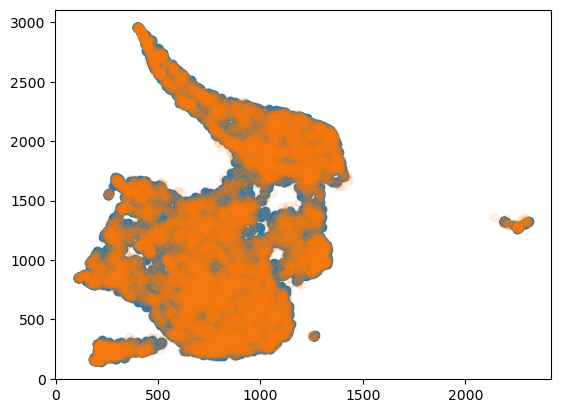

In [ ]:
feature_columns = ['ELANE', 'CD57', 'CD45','CD11B', 'SMA',
       'CD16', 'ECAD', 'FOXP3', 'NCAM',
]

feature_data = csv_df[feature_columns].to_numpy()

# # %%
plt.scatter(csv_df['UMAP_X'], csv_df['UMAP_Y'])
regressor = xgb.XGBRegressor(
                 n_estimators=100,
                 max_depth=8)

regressor.fit(feature_data, csv_df[['UMAP_X','UMAP_Y']])
xgb_preds = regressor.predict(feature_data)
plt.scatter(xgb_preds[:,0], xgb_preds[:,1], alpha=0.1)
explainer = shap.Explainer(regressor)

# # %%

In [29]:
shap_values = explainer(feature_data)

In [30]:
shap_values = np.abs(shap_values.values)
alphabetical_features = sorted(feature_columns)
indices = [feature_columns.index(feature) for feature in alphabetical_features]
indices
# shap_values = shap_values[:, alphabetical_features]
alphabetical_shap_values = shap_values[:, indices]
np.save('/Users/swarchol/Downloads/exemplar-001.shap.npy', alphabetical_shap_values)



In [28]:
csv_df.columns

Index(['CellID', 'DNA_6', 'ELANE', 'CD57', 'CD45', 'DNA_7', 'CD11B', 'SMA',
       'CD16', 'DNA_8', 'ECAD', 'FOXP3', 'NCAM', 'X_centroid', 'Y_centroid',
       'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'Solidity', 'Extent', 'Orientation', 'cluster', 'UMAP_X', 'UMAP_Y'],
      dtype='object')

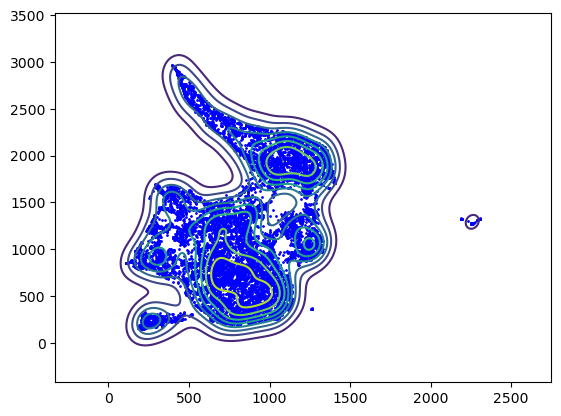

In [32]:
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

# data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 400)
x = csv_df['UMAP_X']
y = csv_df['UMAP_Y']
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Expand the area to ensure contours are complete
xmin_expanded = xmin - (xmax - xmin) * 0.2  # 10% expansion on both sides
xmax_expanded = xmax + (xmax - xmin) * 0.2
ymin_expanded = ymin - (ymax - ymin) * 0.2
ymax_expanded = ymax + (ymax - ymin) * 0.2

# Peform the kernel density estimate with expanded area
xx, yy = np.mgrid[xmin_expanded:xmax_expanded:1024j, ymin_expanded:ymax_expanded:1024j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
import matplotlib.contour as mcontour
fig, ax = plt.subplots()
contours = ax.contour(xx, yy, f, filled=False, levels=np.linspace(f.min(), f.max(), 10))
# plot the scatterplot of the points
plt.scatter(x, y, c='blue', s=1)
contour_lines = []
contours.allsegs
for seg in contours.allsegs:
    for line in seg:
        contour_lines.append(line.tolist())

In [34]:
contour_lines
# write to json
import json
with open('/Users/swarchol/Downloads/exemplar-001.contour.json', 'w') as f:
    json.dump(contour_lines, f)

In [36]:
# csv_df
# Save csv_df as csv and parquet
csv_df.to_csv('/Users/swarchol/Downloads/exemplar-001/updated_hybrid.csv', index=False)
csv_df.to_parquet('/Users/swarchol/Downloads/exemplar-001/updated_hybrid.parquet')

In [38]:
# read parquet /Users/swarchol/Downloads/exemplar-001/test_shap.parquet
test = pd.read_parquet('/Users/swarchol/Downloads/exemplar-001/test_shap.parquet')
test

,CD11B,CD16,CD45,CD57,DNA_6,ECAD,ELANE,FOXP3,NCAM,SMA
0,36.482418,186.655243,316.698151,477.388611,140.831573,327.355865,332.425690,43.026871,132.696671,765.784729
1,15.682800,202.958710,202.631836,421.099792,73.109932,394.725647,172.833557,58.130219,10.739319,459.690338
2,19.346075,29.505150,139.690735,427.974060,122.261467,117.864647,49.641342,66.679718,4.374737,698.362854
3,26.947035,86.482124,160.001526,208.722900,34.888535,215.464279,43.288116,56.428341,17.990971,616.087280
4,5.723450,73.210190,280.299072,423.079895,56.359432,164.799255,14.501699,51.494106,32.157871,667.703918
...,...,...,...,...,...,...,...,...,...,...
11165,19.161755,132.805511,185.959763,233.708313,67.395653,337.229767,53.783447,44.797195,4.094950,413.716309
11166,18.868641,137.126190,259.066833,225.173615,50.215321,329.314880,59.811752,48.995708,10.221527,305.818054
11167,54.830017,101.190216,190.507233,222.326859,56.544609,287.849121,52.552570,43.719643,13.716722,473.237671
11168,18.725449,145.813248,186.263672,235.016541,45.973579,353.693970,36.074810,61.850468,4.212177,331.039459


In [54]:
# make parquet df of alphabetical_shap_values with columns as feature names
import pandas as pd
import numpy as np

alphabetical_shap_values = np.load('/Users/swarchol/Downloads/exemplar-001/exemplar-001.shap.npy')
feature_columns = ['ELANE', 'CD57', 'CD45','CD11B', 'SMA',
       'CD16', 'ECAD', 'FOXP3', 'NCAM',
    ]

# alphabetize feature columns
feature_columns = sorted(feature_columns)

df = pd.DataFrame(np.abs(alphabetical_shap_values).sum(axis=2), columns=feature_columns)
df.to_parquet('/Users/swarchol/Downloads/exemplar-001/test_shap.parquet')

In [55]:
test2 = pd.read_parquet('/Users/swarchol/Downloads/exemplar-001/test_shap.parquet')
test2

,CD11B,CD16,CD45,CD57,ECAD,ELANE,FOXP3,NCAM,SMA
0,69.944313,81.839813,73.782265,305.785858,124.943817,96.390953,84.847908,105.911438,936.318726
1,16.051088,81.605293,222.389099,255.731934,138.893387,34.053398,41.681919,6.280128,540.372314
2,1.025231,52.102882,222.268188,269.365295,129.514099,17.836609,55.709129,37.889076,548.368225
3,11.630646,49.025898,90.683296,181.097229,75.078003,10.513781,51.065407,4.877737,779.576294
4,6.564235,58.886822,299.969238,385.240540,125.929169,12.509375,68.251816,7.484577,828.502930
...,...,...,...,...,...,...,...,...,...
11165,7.557007,81.319122,214.454422,193.104797,126.560387,23.115696,94.682678,5.845111,264.527252
11166,6.847636,66.764694,294.093689,182.623352,128.640320,26.684361,97.369789,6.151150,191.326202
11167,45.795082,62.328369,127.153198,157.179886,107.402672,28.478090,64.792938,10.782970,713.960266
11168,11.948329,75.840805,224.381287,171.883530,117.118729,19.399691,92.536591,6.365380,250.418228


In [56]:
test = pd.read_parquet('/Users/swarchol/Downloads/shap.parquet')
test

,CD11B,CD16,CD45,CD57,DNA_6,ECAD,ELANE,FOXP3,NCAM,SMA
0,36.482418,186.655243,316.698151,477.388611,140.831573,327.355865,332.425690,43.026871,132.696671,765.784729
1,15.682800,202.958710,202.631836,421.099792,73.109932,394.725647,172.833557,58.130219,10.739319,459.690338
2,19.346075,29.505150,139.690735,427.974060,122.261467,117.864647,49.641342,66.679718,4.374737,698.362854
3,26.947035,86.482124,160.001526,208.722900,34.888535,215.464279,43.288116,56.428341,17.990971,616.087280
4,5.723450,73.210190,280.299072,423.079895,56.359432,164.799255,14.501699,51.494106,32.157871,667.703918
...,...,...,...,...,...,...,...,...,...,...
11165,19.161755,132.805511,185.959763,233.708313,67.395653,337.229767,53.783447,44.797195,4.094950,413.716309
11166,18.868641,137.126190,259.066833,225.173615,50.215321,329.314880,59.811752,48.995708,10.221527,305.818054
11167,54.830017,101.190216,190.507233,222.326859,56.544609,287.849121,52.552570,43.719643,13.716722,473.237671
11168,18.725449,145.813248,186.263672,235.016541,45.973579,353.693970,36.074810,61.850468,4.212177,331.039459


In [60]:
from ome_types import from_tiff
from tifffile import tiffcomment

ome_xml = from_tiff(IMG_PATH)
ome_xml
ome_xml = ome_xml.to_xml()
# TIFF strings must be 7-bit ASCII
ome_xml = ome_xml.encode('utf-8')

# write to OUTPUT_TIFF_PATH
tiffcomment(OUTPUT_TIFF_PATH, ome_xml)